In [1]:
import argparse
from open_flamingo import create_model_and_transforms
# grab model checkpoint from huggingface hub
from huggingface_hub import hf_hub_download
import os
import pandas as pd
import torch
import random
from PIL import Image
import time

def inference(demo_images, query, max_new_tokens=20, verbose=True):
    """
    Step 2: Preprocessing images
    Details: For OpenFlamingo, we expect the image to be a torch tensor of shape 
    batch_size x num_media x num_frames x channels x height x width. 
    In this case batch_size = 1, num_media = 3, num_frames = 1,
    channels = 3, height = 224, width = 224.
    """
    vision_x = []

    for img in demo_images:
        vision_x.append(image_processor(img).unsqueeze(0))

    vision_x = torch.cat(vision_x, dim=0)
    vision_x = vision_x.unsqueeze(1).unsqueeze(0)
    
    """
    Step 3: Preprocessing text
    Details: In the text we expect an <image> special token to indicate where an image is.
    We also expect an <|endofchunk|> special token to indicate the end of the text 
    portion associated with an image.
    """
    tokenizer.padding_side = "left" # For generation padding tokens should be on the left
    lang_x = tokenizer(
        [query],
        return_tensors="pt",
    )

    """
    Step 4: Generate text
    """
    generated_text = model.generate(
        vision_x=vision_x.cuda(),
        lang_x=lang_x["input_ids"].cuda(),
        attention_mask=lang_x["attention_mask"].cuda(),
        max_new_tokens=max_new_tokens,
        num_beams=1,
    )
    torch.cuda.empty_cache()

    generated_text = tokenizer.decode(generated_text[0][len(lang_x["input_ids"][0]):])
    if verbose:
        print("### Generated text: ", generated_text)
    return generated_text

/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/custom_envs/icl/lib/python3.9/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
model, image_processor, tokenizer = create_model_and_transforms(
    clip_vision_encoder_path="ViT-L-14",
    clip_vision_encoder_pretrained="openai",
    lang_encoder_path="anas-awadalla/mpt-1b-redpajama-200b",
    tokenizer_path="anas-awadalla/mpt-1b-redpajama-200b",
    cross_attn_every_n_layers=1,
    # cache_dir="/scratch/workspace/asureddy_umass_edu-llm_alignment/hf-cache"  # Defaults to ~/.cache
    )
    
checkpoint_path = hf_hub_download("openflamingo/OpenFlamingo-3B-vitl-mpt1b", "checkpoint.pt")
model.load_state_dict(torch.load(checkpoint_path), strict=False)
model.to("cuda")

print("Model Loaded")

A new version of the following files was downloaded from https://huggingface.co/anas-awadalla/mpt-1b-redpajama-200b:
- configuration_mosaic_gpt.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/anas-awadalla/mpt-1b-redpajama-200b:
- mosaic_gpt.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/project/pi_hongyu_umass_edu/zonghai/clinical-llm-alignment/durga_sandeep/custom_envs/icl/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://g

You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.
Flamingo model initialized with 1046992944 trainable parameters
Model Loaded


### Few-Shot Prompt
- 0, 2, 4, 8 - 100 classes with 10 examples each

In [3]:
test_data = pd.read_pickle("stanford_cars_test_data_1k_samples.pickle")
print(test_data.shape)
test_data.head(3)

(1000, 4)


,image,class,true_class_name,image_path
2478,02479.jpg,83,Dodge Caliber Wagon 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...
7215,07216.jpg,83,Dodge Caliber Wagon 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...
3898,03899.jpg,83,Dodge Caliber Wagon 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...


In [4]:
rice_data = pd.read_pickle("stanford_cars_rice_data_1k_samples.pickle")
print(rice_data.shape)
rice_data.head(4)

(96, 4)


,image,class,true_class_name,image_path
7585,07586.jpg,14,Audi TTS Coupe 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...
6405,06406.jpg,3,Acura TL Sedan 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...
6227,06228.jpg,106,Ford F-450 Super Duty Crew Cab 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...
4210,04211.jpg,96,Dodge Charger Sedan 2012,/scratch/workspace/dsaluru_umass_edu-email/sta...


### RICE Embeddings

In [5]:
# rice embedding based demonstrations
rice_embeddings = pd.read_pickle("rice_embeddings_demonstrations.pickle")
reference_image_paths = rice_embeddings['image_path'].tolist()
reference_embeddings = [x for x in rice_embeddings['rice_embeddings'].tolist()]
reference_embeddings = torch.stack(reference_embeddings, dim=0)

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import open_clip
import torch
from tqdm import tqdm
import torch
class RICES:
    def __init__(
        self,
        vision_encoder_path="ViT-B-32",
        vision_encoder_pretrained="openai"
    ):

        # Load the model and processor
        vision_encoder, _, image_processor = open_clip.create_model_and_transforms(
            vision_encoder_path,
            pretrained=vision_encoder_pretrained,
        )
        self.model = vision_encoder.to("cuda")
        self.image_processor = image_processor

    def get_rice_embedding(self, image_path):
        """
        Compute RICE embedding for a single image.
        Args:
            image_path (str): Path to the image.
        Returns:
            torch.Tensor: Normalized RICE embedding.
        """
        self.model.eval()
        with torch.no_grad():
            image = Image.open(image_path)#.convert("RGB")
            input_tensor = self.image_processor(image).unsqueeze(0).to("cuda")
            embedding = self.model.encode_image(input_tensor)
            embedding /= embedding.norm(dim=-1, keepdim=True)
        return embedding.cpu()

    def get_rice_embeddings_for_list(self, image_paths):
        """
        Compute RICE embeddings for a list of image paths.
        Args:
            image_paths (list): List of image paths.
        Returns:
            torch.Tensor: Stacked embeddings for all images in the list.
        """
        embeddings = []
        for image_path in tqdm(image_paths, desc="Generating embeddings for list"):
            embeddings.append(self.get_rice_embedding(image_path))
        return torch.cat(embeddings)

    def find_top_k_similar(self, query_image_path, reference_image_paths, reference_embeddings, num_examples):
        """
        Find the top-k most similar images from a list of precomputed embeddings.
        Args:
            query_image_path (str): Path to the query image.
            reference_embeddings (torch.Tensor): Precomputed RICE embeddings.
            num_examples (int): Number of most similar images to retrieve.
        Returns:
            list: Indices of the top-k similar images.
        """
        self.model.eval()
        with torch.no_grad():
            query_embedding = self.get_rice_embedding(query_image_path)
            similarity = (query_embedding @ reference_embeddings.T).squeeze()
            indices = similarity.argsort(dim=-1, descending=True)[:num_examples]

        return indices.tolist(), [reference_image_paths[x] for x in indices.tolist()]

    def plot_top_k_similar(self, query_image_path, reference_image_paths, reference_embeddings, num_examples):
        """
        Plot the query image alongside its top-k similar images.
        Args:
            query_image_path (str): Path to the query image.
            reference_image_paths (list): List of paths for reference images.
            reference_embeddings (torch.Tensor): Precomputed embeddings of reference images.
            num_examples (int): Number of most similar images to display.
        """
        # Fetch indices of the top-k similar images
        top_k_indices, _ = self.find_top_k_similar(query_image_path, reference_image_paths, reference_embeddings, num_examples)
        
        # Load the query image
        query_image = Image.open(query_image_path).convert("RGB")
        
        # Load the top-k similar images
        similar_images = [Image.open(reference_image_paths[i]).convert("RGB") for i in top_k_indices]

        # Plot the query image and top-k similar images
        plt.figure(figsize=(15, 5))
        plt.subplot(1, num_examples + 1, 1)
        plt.imshow(query_image)
        plt.axis("off")
        plt.title("Query Image")
        
        for i, img in enumerate(similar_images):
            plt.subplot(1, num_examples + 1, i + 2)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Similar {i+1}")

        plt.tight_layout()
        plt.show()

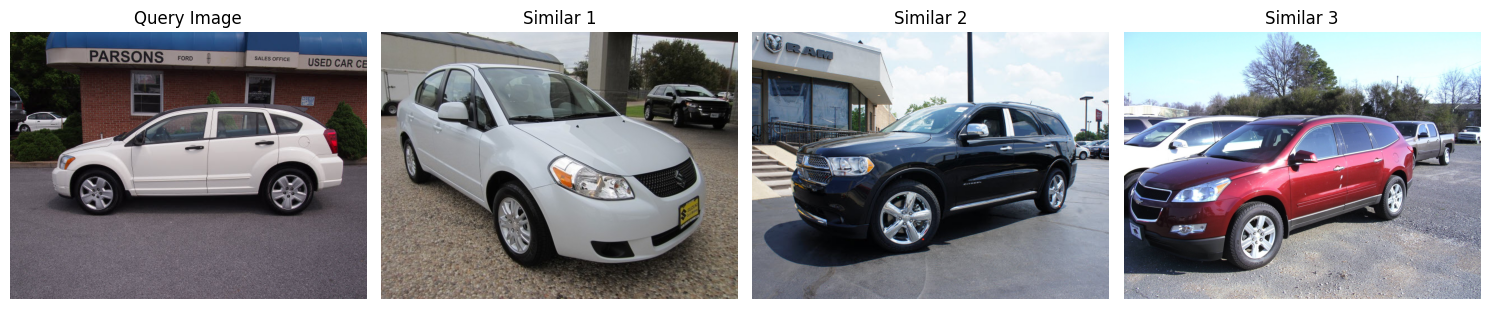

In [7]:
rice = RICES()

query_image_path = test_data.iloc[0]['image_path']
rice.plot_top_k_similar(
    query_image_path=query_image_path,
    reference_image_paths=reference_image_paths,
    reference_embeddings=reference_embeddings,
    num_examples=3  # Top 3 similar images
)

In [8]:
_, top_k = rice.find_top_k_similar(
    query_image_path=query_image_path,
    reference_image_paths=reference_image_paths,
    reference_embeddings=reference_embeddings,
    num_examples=3  # Top 3 similar images
)
top_k

['/scratch/workspace/dsaluru_umass_edu-email/stanford_cars/stanford_cars/cars_train/cars_train/07929.jpg',
 '/scratch/workspace/dsaluru_umass_edu-email/stanford_cars/stanford_cars/cars_train/cars_train/01242.jpg',
 '/scratch/workspace/dsaluru_umass_edu-email/stanford_cars/stanford_cars/cars_train/cars_train/00135.jpg']

In [9]:
n_few_shot = 2
count = 0

test_set = []
for test_idx in range(len(test_data)):

    if test_idx%100 == 0:
        print(f"######################## {test_idx} processed")
    sample = test_data.iloc[test_idx]
    
    target_label = sample['true_class_name']
    curr_image_path = sample['image_path']

    # random demonstrations
    random.seed(count)
    indexes, pick_n_files_names = rice.find_top_k_similar(
        query_image_path=curr_image_path,
        reference_image_paths=reference_image_paths,
        reference_embeddings=reference_embeddings,
        num_examples=n_few_shot
    )
    pick_n_files = []
    for rd_idx in indexes:
        ex_image_path = rice_data.iloc[rd_idx]['image_path']
        ex_label = rice_data.iloc[rd_idx]['true_class_name']
        ex_demo_image = Image.open(ex_image_path)
        pick_n_files.append((ex_demo_image, ex_label))
    
    curr_demo_images = []
    few_shot_query =f""""""
    for k in range(n_few_shot):
        curr_demo_images.append(pick_n_files[k][0])
        few_shot_query += f"<image>\nQuestion: Identify and classify the car in the provided image. Provide the label in the exact format: [Make] [Model] [Year].\nAnswer: {pick_n_files[k][1]} |<endofchunk>|\n\n"
    
    
    # add test sample
    curr_demo_image = Image.open(curr_image_path)
    curr_demo_images.append(curr_demo_image)
    few_shot_query += "<image>\nQuestion: Identify and classify the car in the provided image. Provide the label in the exact format: [Make] [Model] [Year].\nAnswer:"
    
    test_set.append([test_idx, target_label, pick_n_files_names, few_shot_query, curr_demo_images])
    count += 1

######################## 0 processed
######################## 100 processed
######################## 200 processed
######################## 300 processed
######################## 400 processed
######################## 500 processed
######################## 600 processed
######################## 700 processed
######################## 800 processed
######################## 900 processed


In [10]:
def plt_image(image_path):
    query_image = Image.open(image_path).convert("RGB")
    # Plot the query image and top-k similar images
    plt.figure(figsize=(15, 5))
    plt.imshow(query_image)
    plt.show()

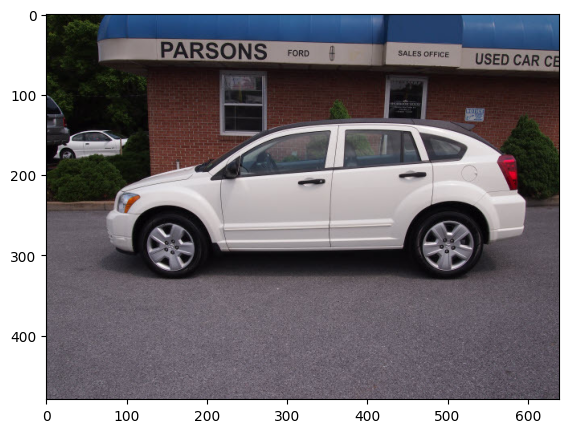

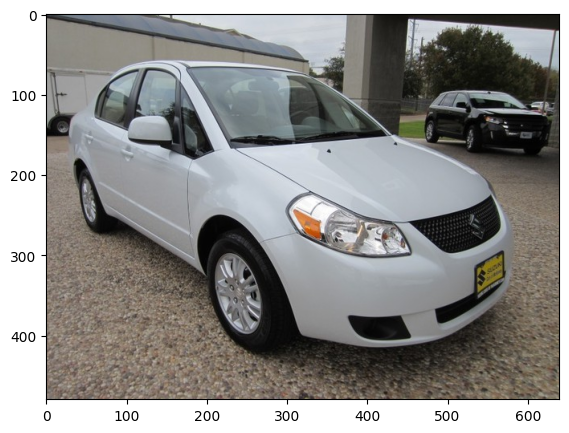

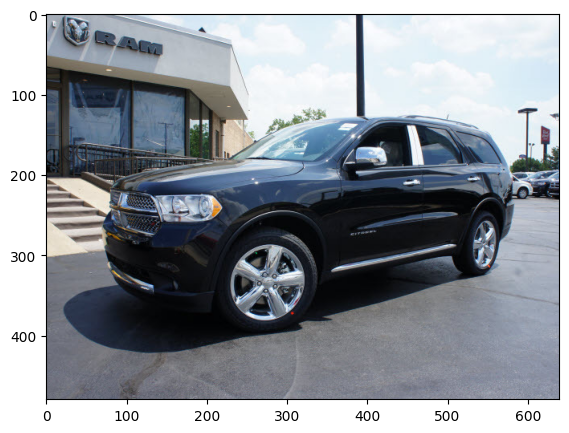

In [11]:
idx=0
plt_image(test_data.iloc[0]['image_path'])
for i in range(n_few_shot):
    plt_image(f"{test_set[idx][2][i]}")

In [12]:
test_df = pd.DataFrame(test_set, columns = ['index', 'target_label', 'pick_n_files_names', 'few_shot_query', 'demo_images'])
print(test_df.shape)
test_df.head(2)

(1000, 5)


,index,target_label,pick_n_files_names,few_shot_query,demo_images
0,0,Dodge Caliber Wagon 2012,[/scratch/workspace/dsaluru_umass_edu-email/st...,<image>\nQuestion: Identify and classify the c...,[<PIL.JpegImagePlugin.JpegImageFile image mode...
1,1,Dodge Caliber Wagon 2012,[/scratch/workspace/dsaluru_umass_edu-email/st...,<image>\nQuestion: Identify and classify the c...,[<PIL.JpegImagePlugin.JpegImageFile image mode...


### test the prompt

In [13]:
sample = test_df.iloc[5]
curr_generated_response = inference(demo_images=sample['demo_images'], query=sample['few_shot_query'], max_new_tokens=15, verbose=False)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [14]:
sample['target_label']

'Dodge Caliber Wagon 2012'

In [15]:
print(curr_generated_response)

 Dodge Caliber Sedan 2008 |<endofchunk>|<|endofchunk|>


In [16]:
print(sample['few_shot_query'])

<image>
Question: Identify and classify the car in the provided image. Provide the label in the exact format: [Make] [Model] [Year].
Answer: GMC Terrain SUV 2012 |<endofchunk>|

<image>
Question: Identify and classify the car in the provided image. Provide the label in the exact format: [Make] [Model] [Year].
Answer: Suzuki Aerio Sedan 2007 |<endofchunk>|

<image>
Question: Identify and classify the car in the provided image. Provide the label in the exact format: [Make] [Model] [Year].
Answer:


### Run the model

In [ ]:
print("######### Running inference")

start = time.time()

all_responses = []
for i in range(len(test_df)):
    if i%200 == 0:
        print(f"############### {i} values are processed")

    sample = test_df.iloc[i]
    curr_generated_response = inference(demo_images=sample['demo_images'], query=sample['few_shot_query'], max_new_tokens=15, verbose=False)
    all_responses.append(curr_generated_response)
    torch.cuda.empty_cache()
end = time.time()

print("############# Total time taken for inference : ", (end-start))

######### Running inference
############### 0 values are processed


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

############### 200 values are processed


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

In [51]:
test_df['raw_responses'] = all_responses
test_df.drop(['demo_images'], axis=1).to_pickle("rice_zero_shot.pickle")
test_df['predicted_label'] = test_df['raw_responses'].apply(lambda x: x.split(" |")[0][1:])
acc = test_df[test_df.apply(lambda x: 1 if (x['predicted_label'] in x['target_label']) else 0, 1) == 1].shape[0]/len(test_df)
print(f"Accuracy at {4} shot: ", acc)
test_df.drop(['demo_images'], axis=1).to_pickle("rice_zero_shot.pickle")

Accuracy at 4 shot:  0.197
Saved at ./data/imagenet_sample_test_dataset_1k_with_random_four_shot_prompt.pickle


### RICE few-shot performance

1. 2 - 
2. 4 - 
3. 8 - 